In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
!ls *.csv

credits_clean.csv
keywords_clean.csv
links_clean.csv
metadata_clean.csv


# Linear regression

In [3]:
meta = pd.read_csv('metadata_clean.csv')

In [4]:
meta.head()

,release_date,adult,genres,id,original_language,overview,popularity,production_countries,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,1878-06-14,False,"[{'id': 99, 'name': 'Documentary'}]",194079.0,en,Sallie Gardner at a Gallop was one of the earl...,0.327841,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Sallie Gardner at a Gallop,False,6.2,25.0
1,1883-11-19,False,"[{'id': 99, 'name': 'Documentary'}]",426903.0,en,Individual photographs of the running of a buf...,0.229221,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Buffalo Running,False,5.4,7.0
2,1890-03-09,False,[],386743.0,en,Shot of the flight of a fly.,0.071756,[],1.0,[],Released,Mosquinha,False,6.5,2.0
3,1890-11-21,False,"[{'id': 35, 'name': 'Comedy'}]",32571.0,en,Experimental film made to test the original cy...,1.163672,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,[],Released,"Monkeyshines, No. 1",False,4.3,15.0
4,1891-01-01,False,"[{'id': 99, 'name': 'Documentary'}]",336380.0,fr,This early cinematic instance of a close-up—or...,0.212894,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Je Vous Aime,False,3.3,3.0


In [5]:
meta.release_date = pd.to_datetime(meta.release_date, format='%Y-%m-%d')

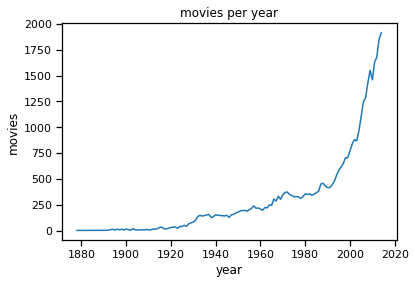

In [72]:
data = meta.release_date.dt.year.value_counts().sort_index()
X = np.array(data.index)[:-5].reshape(-1, 1)
y = data.values[:-5]
plt.plot(X, y)
plt.title('movies per year')
plt.ylabel('movies')
plt.xlabel('year')
plt.savefig('movie_per_year2.jpg', bbox_inches='tight', dpi=1200)

**I use sqrt transformation of y value to use linear regression with second degree polynomilas**

In [51]:
# transforming the y value, using sqrt

y_tr = np.sqrt(y)
X_train = X[:]
y_train = y_tr[:]
X_test = X[:]
y_test = y_tr[:]

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

In [53]:
linreg = LinearRegression()
neighbor = KNeighborsRegressor(n_neighbors = 10)

In [54]:
poly = PolynomialFeatures(degree = 2)
higher_x = poly.fit_transform(X_train)
higher_test = poly.transform(X)
linreg.fit(higher_x, y_train)
linreg_pred = linreg.predict(higher_test)
print("the value of R^2 for the linear regression: {}".format(linreg.score(higher_test, y_tr)))

the value of R^2 for the linear regression: 0.9406259651814423


In [55]:
neighbor.fit(X_train, y_train)
neighbor_pred = neighbor.predict(X)

**A comparison between nearest neighbors regression and linear regression**

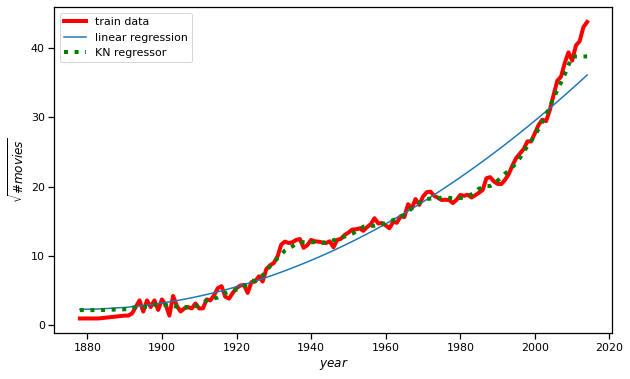

In [60]:
sns.set_context('notebook')
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, linewidth=4, color='red', label = 'train data')
plt.plot(X, linreg_pred, label = 'linear regression')
plt.plot(X, neighbor_pred, label = 'KN regressor', color='green', linestyle='dotted', linewidth=4)
plt.legend()
plt.ylabel("$\sqrt{\# movies}$")
plt.xlabel('$year$')
plt.savefig('knn_reg.jpg', bbox_inches='tight', dpi=1200)

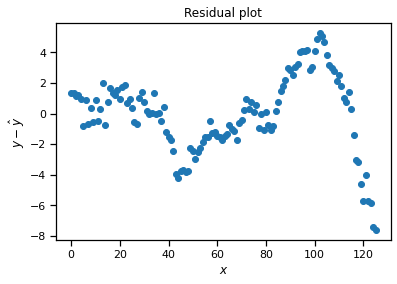

In [62]:
# plotting the residual plot
plt.plot(linreg_pred - y_tr, linestyle='None', marker='o')
plt.title('Residual plot')
plt.ylabel('$y - \hat{y}$')
plt.xlabel('$x$')
plt.savefig('residual_.jpg', bbox_inches='tight', dpi=1200)

# Cluster analysis

## Full data

In [56]:
from scipy.sparse import csr_matrix

file=pd.read_csv(r'the-movies-dataset\ratings.csv')
file = file.drop('timestamp', axis=1)
user_u = list(sorted(file.userId.unique()))
item_u = list(sorted(file.movieId.unique()))

row = file.userId.astype('category', categories=user_u).cat.codes
col = file.movieId.astype('category', categories=item_u).cat.codes
data = file['rating'].tolist()
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))

C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if __name__ == '__main__':


**instead of making a pivot table out of the full data, which would take around 100 GB of memory, I used sparse matrix to save the pivot table into, also I used the Truncated SVD to decrease the dimensions of this data to 100 columns ( although just accounts for around 43% of the variance in the data. In the next section I will use a sample of this data and further analyse that**

In [59]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 100)
transformed = svd.fit_transform(sparse_matrix)

In [60]:
# the amount of variance in the data that is reflected in the dimension reduced version
svd.explained_variance_ratio_.cumsum()[-1]

0.42504683475254823

In [61]:
transformed.shape

(270896, 100)

In [62]:
from sklearn.cluster import KMeans

inertias = []
k_vals = range(2, 8)
for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(transformed)
    inertias.append(model.inertia_)

Text(0, 0.5, 'Inertia')

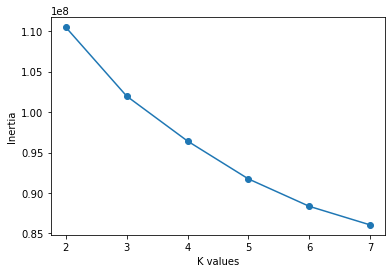

In [63]:
plt.plot(k_vals, inertias, marker = 'o')
plt.xlabel("K values")
plt.ylabel("Inertia")

**based on the values above, there is no clear "elbow" point to specify the value of cluster numbers from**

**Below, I use only 2 components to try to visualize the data**

In [77]:
svd2 = TruncatedSVD(n_components=2)
full_tr = svd2.fit_transform(sparse_matrix)

Text(0, 0.5, 'PC2')

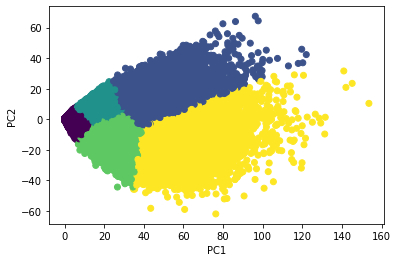

In [80]:
km = KMeans(n_clusters=5)
km.fit(full_tr)
plt.scatter(full_tr[:, 0], full_tr[:, 1], c = km.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [83]:
print("2 prencipal components just account for {:.2f} % of variance in the original data".format(svd2.explained_variance_ratio_.cumsum()[1]))

2 prencipal components just account for 0.17 % of variance in the original data


## A sub sample of the full date

In [7]:
small = pd.read_csv(r'the-movies-dataset\ratings_small.csv')

In [10]:
links = pd.read_csv('links_clean.csv')

In [11]:
links.head()

,Unnamed: 0,movieId,imdbId,tmdbId
0,0,1,114709,862
1,1,2,113497,8844
2,2,3,113228,15602
3,3,4,114885,31357
4,4,5,113041,11862


In [19]:
small2 = pd.merge(small, links, left_on = 'movieId', right_on='movieId')[['userId', 'tmdbId', 'rating', 'timestamp']]
small2.rename(columns={'tmdbId':'movieId'}, inplace=True)
small2.head()

,userId,movieId,rating,timestamp
0,1,9909,2.5,1260759144
1,7,9909,3.0,851868750
2,31,9909,4.0,1273541953
3,32,9909,4.0,834828440
4,36,9909,3.0,847057202


In [75]:
len(small2.userId.unique())

671

In [20]:
small2.shape

(99898, 4)

In [8]:
small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [9]:
meta.head()

,release_date,adult,genres,id,original_language,overview,popularity,production_countries,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,1878-06-14,False,"[{'id': 99, 'name': 'Documentary'}]",194079.0,en,Sallie Gardner at a Gallop was one of the earl...,0.327841,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Sallie Gardner at a Gallop,False,6.2,25.0
1,1883-11-19,False,"[{'id': 99, 'name': 'Documentary'}]",426903.0,en,Individual photographs of the running of a buf...,0.229221,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Buffalo Running,False,5.4,7.0
2,1890-03-09,False,[],386743.0,en,Shot of the flight of a fly.,0.071756,[],1.0,[],Released,Mosquinha,False,6.5,2.0
3,1890-11-21,False,"[{'id': 35, 'name': 'Comedy'}]",32571.0,en,Experimental film made to test the original cy...,1.163672,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,[],Released,"Monkeyshines, No. 1",False,4.3,15.0
4,1891-01-01,False,"[{'id': 99, 'name': 'Documentary'}]",336380.0,fr,This early cinematic instance of a close-up—or...,0.212894,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Je Vous Aime,False,3.3,3.0


In [26]:
small.shape

(100004, 4)

**A pivot table consisting of movies as the columns and users as the rows**

In [21]:
small_pt = pd.pivot_table(small2, values = 'rating', index = 'userId', columns='movieId', fill_value=0)

**decreasing the data dimensions using PCA, so that the reduced data accounts for more than 90% of the data**

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
small_tr = pca.fit_transform(small_pt)

In [23]:
pca.explained_variance_ratio_.cumsum()[-1]

0.9059176309015997

In [24]:
from sklearn.cluster import KMeans

k_vals = range(2, 11)
inertias = []
for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(small_tr)
    inertias.append(model.inertia_)

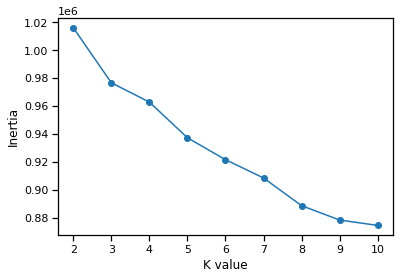

In [63]:
plt.plot(k_vals, inertias, marker = 'o')
plt.xlabel("K value")
plt.ylabel('Inertia')
plt.savefig('k_elbow_users.jpg', bbox_inches='tight', dpi=1200)

**Based on the figure above, no clear "elbow" is to be observed**

**Yet using another measure to find the true cluster number, the silhouette score**

In [26]:
from sklearn.metrics import silhouette_score

for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(small_tr)
    print("for {} clusters, silhouette score of {}".format(k, silhouette_score(small_tr, model.labels_)))

for 2 clusters, silhouette score of 0.414034591270246
for 3 clusters, silhouette score of 0.27034637970836223
for 4 clusters, silhouette score of 0.2767014436080116
for 5 clusters, silhouette score of 0.03764805231042215
for 6 clusters, silhouette score of 0.257981629971732
for 7 clusters, silhouette score of 0.028863822254685676
for 8 clusters, silhouette score of 0.03133720877495691
for 9 clusters, silhouette score of 0.04795154324606391
for 10 clusters, silhouette score of 0.06955689668084838


**based on the values of filhouette scores above, 2 to 5 clusters seem more promising...**

**Using t-SNE in order to visualize the data in 2 dimensions and hopefully see the cluster patterns**

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate = 200)
tr = tsne.fit_transform(small_pt)

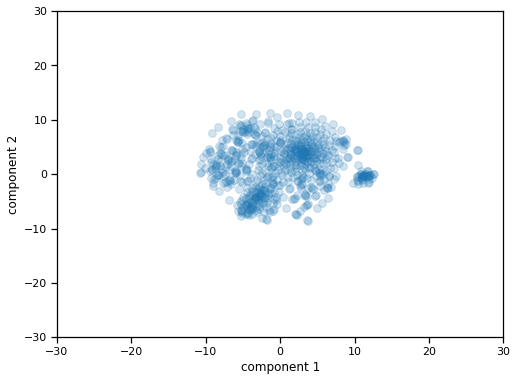

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(tr[:, 0], tr[:, 1], alpha=.2, s=60)
plt.axis([-30, 30, -30, 30])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.savefig('tsne_users.jpg', bbox_inches='tight', dpi=1200)

**Visualization using PCA**

In [29]:
small_pca = PCA(n_components=2).fit_transform(small_pt)

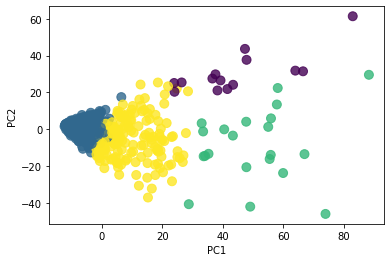

In [43]:
model = KMeans(n_clusters=4)
model.fit(small_pt)
pred = model.labels_
plt.scatter(small_pca[:, 0], small_pca[:, 1], c = pred, alpha=.8, s=80)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('PC components.jpg', bbox_inches='tight', dpi=1200)

In [33]:
userid = small_pt.index.tolist()
labels = pred
user_label = dict(zip(userid, labels))

In [34]:
small2['label'] = small2.userId.map(user_label)

In [35]:
small2.head()

,userId,movieId,rating,timestamp,label
0,1,9909,2.5,1260759144,1
1,7,9909,3.0,851868750,1
2,31,9909,4.0,1273541953,2
3,32,9909,4.0,834828440,1
4,36,9909,3.0,847057202,1


In [36]:
# merging the movie titles with the dataframe
merged = pd.merge(small2, meta[['title', 'id']], left_on = 'movieId', right_on='id')

In [37]:
merged.drop(['timestamp', 'id'], axis=1, inplace=True)
merged.head()

,userId,movieId,rating,label,title
0,1,9909,2.5,1,Dangerous Minds
1,7,9909,3.0,1,Dangerous Minds
2,31,9909,4.0,2,Dangerous Minds
3,32,9909,4.0,1,Dangerous Minds
4,36,9909,3.0,1,Dangerous Minds


In [38]:
grouped = merged.groupby('label')     #.apply(lambda x: x.title.value_counts()[:10])

In [39]:
keys = grouped.groups.keys()

**In the subplots below, i will visualize the top 10 most viewed movies per each cluster**

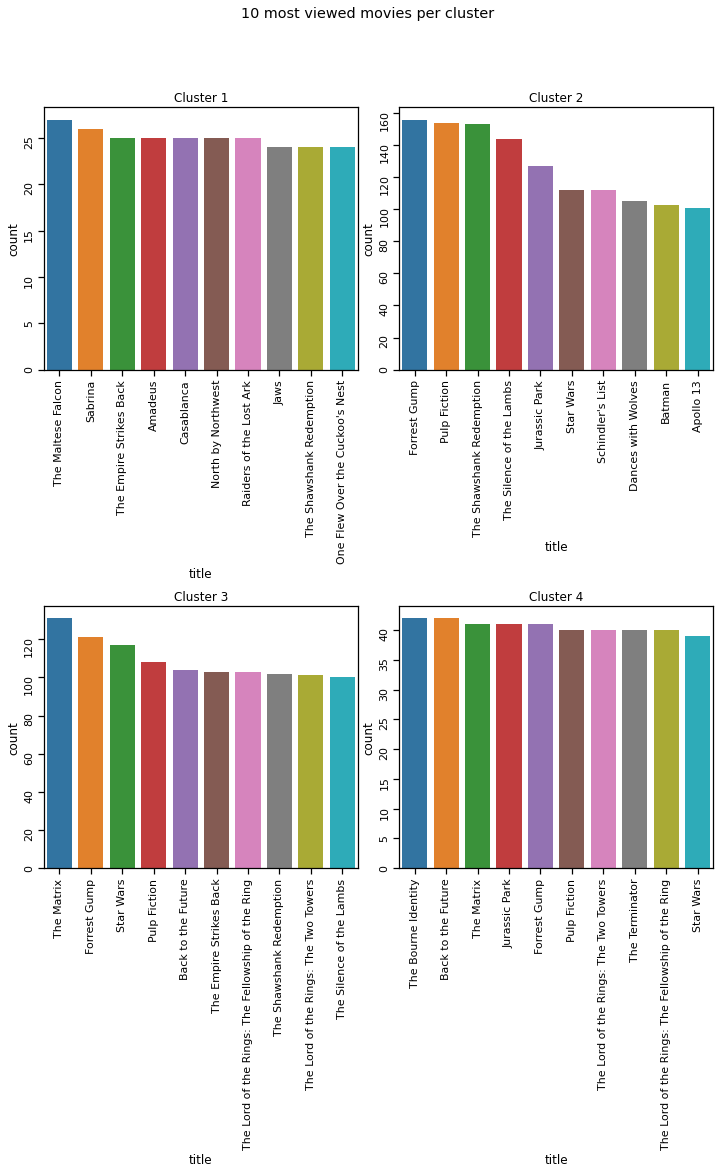

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 14))
zipped = zip(keys, axes.flatten())
for key, ax in zipped:
    group = grouped.get_group(key)
    order = group.title.value_counts()[:10].index
    sns.countplot(x = 'title', data=group, order = order, ax = ax)
    ax.tick_params(rotation=90)
    ax.set_title("Cluster {}".format(key+1))
    
plt.subplots_adjust(wspace=.13, hspace=.9)
plt.suptitle("10 most viewed movies per cluster")
plt.savefig('cluster movies.jpg', bbox_inches='tight')